# 计算rmsd inplace

In [21]:
import os
# The powerful libraries from rdkit I will use:
from rdkit import Chem
from rdkit.Chem import rdFMCS,AllChem, Draw
from rdkit.Chem.Draw import DrawingOptions

# Other powerful python libraries:
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec

# All we need for clustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [22]:
poses=Chem.SDMolSupplier('test.sdf')
renamed_poses=[]
for index,p in enumerate(poses):
    p.SetProp('_Name',str(index+1))
    renamed_poses.append(p)

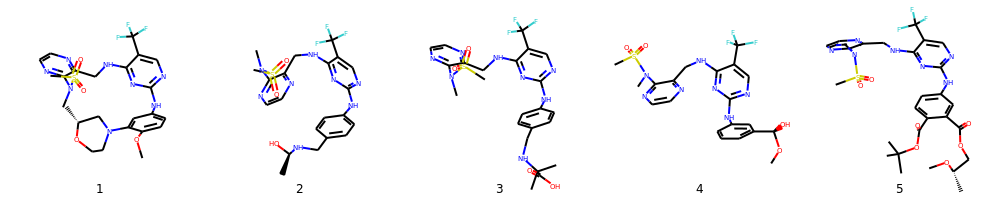

In [23]:
# If all molecules are correct (sanitized), Draw.MolsToGridImage must work 
img=Draw.MolsToGridImage(renamed_poses,molsPerRow=(5),legends=[i.GetProp('_Name') for i in renamed_poses],useSVG=False)
img

In [24]:
size = len(renamed_poses)
hmap=np.empty(shape=(size,size))
table=pd.DataFrame()
for i,mol in enumerate(renamed_poses):
    for j,jmol in enumerate(renamed_poses):
        # MCS identification between reference pose and target pose
        r=rdFMCS.FindMCS([mol,jmol])
        # Atom map for reference and target              
        a=mol.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))
        b=jmol.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))
        # Atom map generation     
        amap=list(zip(a,b))
        
        # distance calculation per atom pair
        distances=[]
        for atomA, atomB in amap:
            pos_A=mol.GetConformer().GetAtomPosition (atomA)
            pos_B=jmol.GetConformer().GetAtomPosition (atomB)
            coord_A=np.array((pos_A.x,pos_A.y,pos_A.z))
            coord_B=np.array ((pos_B.x,pos_B.y,pos_B.z))
            dist_numpy = np.linalg.norm(coord_A-coord_B)        
            distances.append(dist_numpy)
                         
        # This is the RMSD formula from wikipedia
        rmsd=math.sqrt(1/len(distances)*sum([i*i for i in distances])) 
        
        #saving the rmsd values to a matrix and a table for clustering
        hmap[i,j]=rmsd
        table.loc[mol.GetProp('_Name'),jmol.GetProp('_Name')]=rmsd

In [25]:
table

,1,2,3,4,5
1,0.000000,1.883865,2.208929,2.975728,1.732511
2,1.883865,0.000000,2.322021,3.310863,1.956176
3,2.208929,2.322021,0.000000,3.122757,1.782516
4,2.975728,3.310863,3.122757,0.000000,2.844754
5,1.732511,1.956176,1.782516,2.844754,0.000000


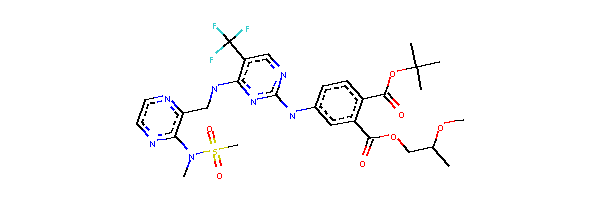

In [26]:
# Atoms that were used for RMSD calculation (Stereochemistry not shown)
DrawingOptions.bondLineWidth=2
DrawingOptions.includeAtomNumbers=False
structure=Draw.MolToImage(Chem.MolFromSmarts(r.smartsString),size=(600,200))
structure

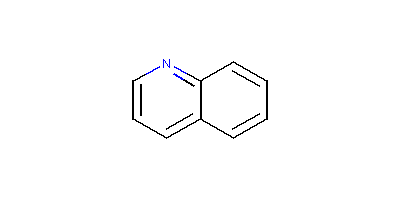

In [27]:
DrawingOptions.bondLineWidth=2
DrawingOptions.includeAtomNumbers=False
Draw.MolToImage(Chem.MolFromSmiles('C1=CC2=CC=CN=C2C=C1'),size=(400,200))

In [28]:
# I will use the matrix that I generated before
linked = linkage(hmap,'complete')
labelList = [mol.GetProp('_Name') for mol in renamed_poses]
# Don´t worry about the warning, the analysis was done

/home/xh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


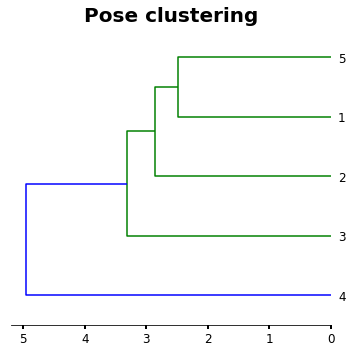

In [29]:
plt.figure(figsize=(5,5))

ax1=plt.subplot()
o=dendrogram(linked,  
            orientation='left',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)

ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.title('Pose clustering',fontsize=20,weight='bold')
plt.tick_params ('both',width=2,labelsize=12)
plt.tight_layout()
plt.show() 

In [30]:
# This will give us the clusters in order as the last plot

new_data=list(reversed(o['ivl']))

# we create a new table with the order of HCL
hmap_2=np.empty(shape=(size,size))
for index,i in enumerate(new_data):
    for jndex,j in enumerate(new_data):
        hmap_2[index,jndex]=table.loc[i].at[j]

In [31]:
hmap_2

array([[0.        , 1.73251062, 1.9561762 , 1.78251584, 2.8447536 ],
       [1.73251062, 0.        , 1.88386531, 2.20892907, 2.97572838],
       [1.9561762 , 1.88386531, 0.        , 2.32202126, 3.3108632 ],
       [1.78251584, 2.20892907, 2.32202126, 0.        , 3.12275721],
       [2.8447536 , 2.97572838, 3.3108632 , 3.12275721, 0.        ]])

[]

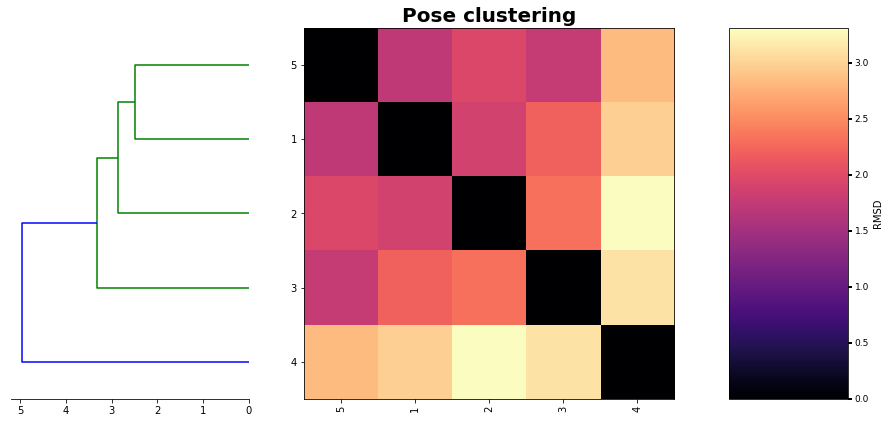

In [32]:
figure= plt.figure(figsize=(15,15))
gs1 = gridspec.GridSpec(2,7)
gs1.update(wspace=0.01)
ax1 = plt.subplot(gs1[0:-1, :2])
dendrogram(linked, orientation='left', distance_sort='descending',show_leaf_counts=True,no_labels=True)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = plt.subplot(gs1[0:-1,2:6])
f=ax2.imshow (hmap_2, cmap='magma', interpolation='nearest')

ax2.set_title('Pose clustering',fontsize=20,weight='bold')
ax2.set_xticks (range(len(new_data)))
ax2.set_yticks (range(len(new_data)))
ax2.set_xticklabels (new_data,rotation=90)
ax2.set_yticklabels (new_data)

ax3 = plt.subplot(gs1[0:-1,6:7])
m=plt.colorbar(f,cax=ax3,shrink=0.75,orientation='vertical',spacing='uniform',pad=0.01)
m.set_label ('RMSD')

plt.tick_params ('both',width=2,labelsize=9)
plt.plot()